- progressively increase size

# params

In [19]:
dbg = False
if dbg:
    dbgsz = 500

PRFX = 'CVProg0710'    
p_o = f'../output/{PRFX}'
SEED = 111

FP16 = False

# setup

In [11]:
import fastai
print('fastai.__version__: ', fastai.__version__)

import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

fastai.__version__:  1.0.54


# preprocess

In [12]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [13]:
img2grd += img2grd_blnd
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

In [14]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

train=pd.read_csv(pp/'trainLabels.csv')
img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1])  for o in train.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'retinopathy_solution.csv')
img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1])  for o in test.values]
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())


38788

[(0, 27615), (2, 6291), (1, 2813), (3, 1066), (4, 1003)]

92364

[(0, 67148), (2, 14152), (1, 6575), (3, 2280), (4, 2209)]

In [15]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)

train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1])  for o in train.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1])  for o in test.values]
img2grd += img2grd_idrid_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

92777

[(0, 67282), (2, 14288), (1, 6595), (3, 2354), (4, 2258)]

92880

[(0, 67316), (2, 14320), (1, 6600), (3, 2373), (4, 2271)]

In [16]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [17]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

df.shape

(92880, 2)

In [18]:
set_torch_seed()
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, int(len_blnd*0.50), replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

if dbg:
    df=df.head(dbgsz)

# dataset

In [20]:
%%time
tfms = get_transforms()

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=sz) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = 256 
sz = 128
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 1min 19s, sys: 35.5 s, total: 1min 55s
Wall time: 1min 24s


CPU times: user 6.2 s, sys: 2.03 s, total: 8.23 s
Wall time: 5min 20s


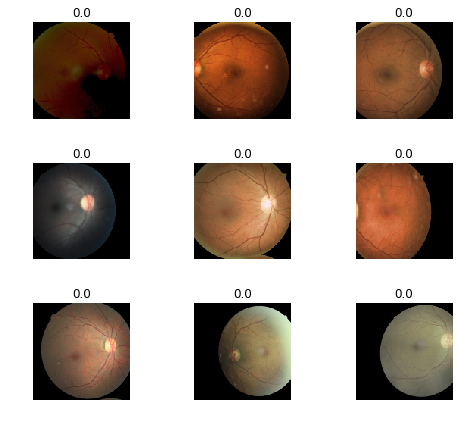

In [21]:
%%time
data.show_batch(rows=3, figsize=(7,6))

# model

In [11]:
%%time
# Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/pytorch-vision-pretrained-models/resnet50-19c8e357.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

CPU times: user 3.67 ms, sys: 13.1 ms, total: 16.8 ms
Wall time: 926 ms


In [12]:
learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    path=p_o)
learn.loss = MSELossFlat

if FP16: learn = learn.to_fp16()

In [13]:
learn.freeze()

In [14]:
len(learn.data.train_dl)

292

In [15]:
%%time
learn.lr_find(start_lr=1e-4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 13.9 s, sys: 7.16 s, total: 21 s
Wall time: 14min 30s


Min numerical gradient: 2.00E-02
Min loss divided by 10: 1.00E-02


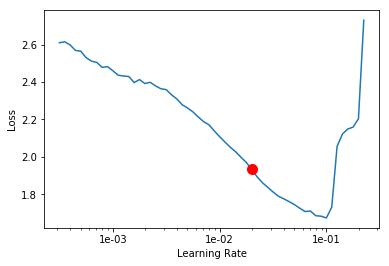

In [16]:
learn.recorder.plot(suggestion=True)

In [17]:
set_torch_seed()
learn.fit_one_cycle(15, max_lr=5e-3, callbacks=[SaveModelCallback(learn, name='bestmodel_frozen')])

epoch,train_loss,valid_loss,time
0,1.073015,0.597575,51:40
1,0.616717,0.437529,53:59
2,0.559660,0.430043,52:05
3,0.532790,0.365194,53:56
4,0.514944,0.444862,52:35
5,0.508639,0.425903,51:59
6,0.482106,0.422852,52:40
7,0.459675,0.321583,53:22
8,0.449519,0.325510,51:19
9,0.428780,0.334543,53:21


Better model found at epoch 0 with valid_loss value: 0.5975754857063293.
Better model found at epoch 1 with valid_loss value: 0.4375292658805847.
Better model found at epoch 2 with valid_loss value: 0.43004322052001953.
Better model found at epoch 3 with valid_loss value: 0.3651939034461975.
Better model found at epoch 7 with valid_loss value: 0.3215833306312561.
Better model found at epoch 10 with valid_loss value: 0.31135186553001404.
Better model found at epoch 11 with valid_loss value: 0.292174756526947.
Better model found at epoch 13 with valid_loss value: 0.2909413278102875.
Better model found at epoch 14 with valid_loss value: 0.2902067005634308.


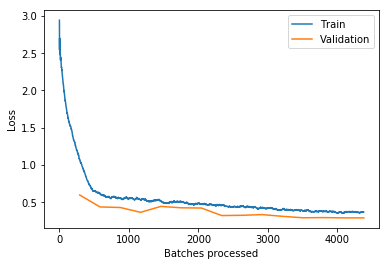

In [18]:
learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [19]:
learn.save('mdl-frozen')

In [20]:
!nvidia-smi

Tue Jul  9 17:07:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P0    50W / 300W |  13913MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 1.00E-06
CPU times: user 19.1 s, sys: 8.56 s, total: 27.7 s
Wall time: 16min


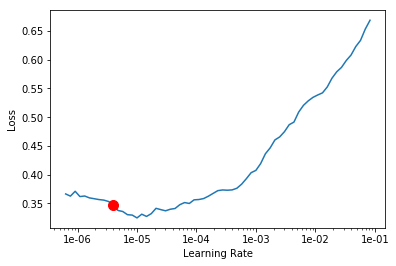

In [22]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [23]:
set_torch_seed()
learn.fit_one_cycle(10, max_lr=slice(5e-7,5e-5), callbacks=[SaveModelCallback(learn, name='bestmodel_finetune')])

epoch,train_loss,valid_loss,time
0,0.374121,0.291850,53:01
1,0.364565,0.290680,53:02
2,0.368613,0.291697,53:21
3,0.352418,0.288288,51:15
4,0.347227,0.284571,53:07
5,0.350286,0.288311,52:09
6,0.344032,0.282360,52:53
7,0.333701,0.285059,52:35
8,0.325340,0.283120,52:29
9,0.311271,0.284726,51:44


Better model found at epoch 0 with valid_loss value: 0.29185014963150024.
Better model found at epoch 1 with valid_loss value: 0.2906801700592041.
Better model found at epoch 3 with valid_loss value: 0.288287878036499.
Better model found at epoch 4 with valid_loss value: 0.2845708131790161.
Better model found at epoch 6 with valid_loss value: 0.2823599576950073.


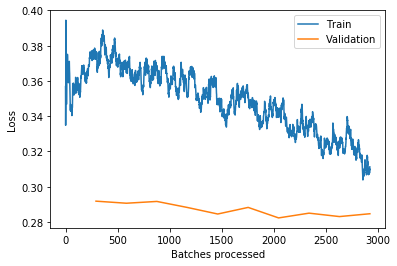

In [24]:
learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [25]:
learn.save('mdl')

In [26]:
!nvidia-smi

Wed Jul 10 02:08:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   35C    P0    46W / 300W |  14033MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# validate and thresholding

In [27]:
learn = learn.to_fp32()

In [28]:
%%time
set_torch_seed()
preds_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)

CPU times: user 1.51 s, sys: 1.26 s, total: 2.77 s
Wall time: 1min 15s


In [29]:
preds_val = preds_val.numpy().squeeze()
y_val= y_val.numpy()

In [30]:
np.save(f'{p_o}/preds_val.npy', preds_val)
np.save(f'{p_o}/y_val.npy', y_val)

In [31]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [32]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [33]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [34]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [35]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

CPU times: user 12.9 s, sys: 0 ns, total: 12.9 s
Wall time: 12.9 s


In [36]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

CPU times: user 1.56 s, sys: 0 ns, total: 1.56 s
Wall time: 1.56 s


In [37]:
optnm2coefs

{'simple': [0.5, 1.5, 2.5, 3.5],
 'hocop1': [1.0000660342883434,
  1.5081937997629595,
  2.545839591401,
  2.8820660342883433],
 'abhishek': array([0.521784, 1.561635, 2.545948, 3.170486])}

In [38]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [39]:
optnm2qwk

{'simple': 0.8984437597110428,
 'hocop1': 0.9035847205445209,
 'abhishek': 0.9033046515033698}

In [40]:
Counter(y_val).most_common()

[(0.0, 885), (2.0, 514), (1.0, 181), (4.0, 152), (3.0, 99)]

In [41]:
preds_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [42]:
preds_val_grd.mean()

1.1567449481157837

In [43]:
Counter(preds_val_grd).most_common()

[(0.0, 875), (2.0, 576), (3.0, 227), (1.0, 109), (4.0, 44)]

In [44]:
list(zip(preds_val_grd, y_val))[:10]

[(2.0, 2.0),
 (3.0, 4.0),
 (0.0, 0.0),
 (2.0, 2.0),
 (2.0, 2.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (2.0, 3.0),
 (1.0, 1.0),
 (2.0, 2.0)]

In [45]:
(preds_val_grd== y_val.squeeze()).mean()

0.7717094483888586

In [46]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

# testing

In [47]:
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [48]:
learn.data.add_test(
    ImageList.from_df(df_test,
                      '../input/aptos2019-blindness-detection',
                      folder='test_images',
                      suffix='.png'))

In [49]:
%%time
set_torch_seed()
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()

CPU times: user 1.73 s, sys: 1.17 s, total: 2.89 s
Wall time: 30 s


In [50]:
np.save(f'{p_o}/preds_tst.npy', preds_tst)

In [51]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [52]:
coef = optnm2coefs['simple']
preds_tst_grd = bucket(preds_tst, coef)

In [53]:
preds_tst_grd.squeeze()

array([1., 2., 2., 1., ..., 2., 3., 3., 3.])

In [54]:
Counter(preds_tst_grd.squeeze()).most_common()

[(2.0, 1069), (1.0, 284), (3.0, 276), (0.0, 271), (4.0, 28)]

## submit

In [55]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst_grd.squeeze().astype(int)
subm.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,1
4,009245722fa4,2


In [56]:
subm.diagnosis.value_counts()

2    1069
1     284
3     276
0     271
4      28
Name: diagnosis, dtype: int64

In [57]:
subm.to_csv(f"{p_o}/submission.csv", index=False)